In [161]:
import pathlib

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from tensorflow.python.client import device_lib

from sklearn.metrics import mean_absolute_error
from keras.regularizers import l2
from modules import plotformodel as pfm
from modules import statistic_function as sf


print(tf.__version__)
'''
GROUP_NAME = "highccgroup"
PATH_TRAIN = "./Dataset/" + GROUP_NAME + "/train.csv"
PATH_TEST = "./Dataset/" + GROUP_NAME + "/test.csv"
PATH_TESTB = "./Dataset/" + GROUP_NAME + "/testB.csv"
PATH_TESTB_INDEX = "./Dataset/" + GROUP_NAME + "/testB_index.csv"
PATH_SAVE_LINEAR = "./models/" + GROUP_NAME + "/linear_model"
PATH_SAVE_DNN = "./models/" + GROUP_NAME + "/dnn_model"
'''
PATH_TRAIN = "./Hierarchical_data_cc/train.csv"
PATH_TEST = "./Hierarchical_data_cc/test.csv"
PATH_SAVE_LINEAR = "./Hierarchical_model/linear_model"
PATH_SAVE_DNN = "./Hierarchical_model/dnn_model"


2.8.0


In [162]:
train_dataset = pd.read_csv(PATH_TRAIN)
test_dataset = pd.read_csv(PATH_TEST)
# test_datasetb = pd.read_csv(PATH_TESTB)
# test_datasetb_index = pd.read_csv(PATH_TESTB_INDEX)
#test_dataset.describe()

In [163]:
train_dataset_interval = train_dataset[["volume", "interval"]].copy()
train_dataset.pop("volume")
# train_dataset.pop("interval")
# drop other featuer when only using average temperature as feature
# train_dataset = train_dataset.drop(columns=["volume","mltemp", "mhtemp","mwind", "msnowacc", "msnow", "msun", "mhumidi", "interval", "price"])

test_dataset_interval = test_dataset[["volume", "interval"]].copy()
test_dataset.pop("volume")
# test_dataset.pop("interval")
# test_dataset = test_dataset.drop(columns=["volume","mltemp", "mhtemp","mwind", "msnowacc", "msnow", "msun", "mhumidi", "interval", "price"])


0      419.1
1      329.1
2      368.1
3      330.4
4      393.9
       ...  
348    246.8
349    142.7
350    161.7
351    243.5
352    198.8
Name: volume, Length: 353, dtype: float64

In [164]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
# train_stats

In [165]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('mean_consumption')
test_labels = test_features.pop('mean_consumption')

In [166]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [167]:
normalized_data = normalizer(train_features)

print("Features mean: %.2f" % (normalized_data.numpy().mean()))
print("Features std: %.2f" % (normalized_data.numpy().std()))

Features mean: -0.00
Features std: 1.00


In [169]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  -0.41    2.53   -3.71    3.39   72.06    2.56    4.86   58.56   18.
    17.91 1952.7    86.      0.99    0.17]]

Normalized: [[-0.34 -0.42 -0.39  0.11  0.86 -0.3   0.91 -2.08  0.93 -0.39 -0.7   0.12
   1.17 -1.58]]


In [170]:
%%time
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=200,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 8.03 s


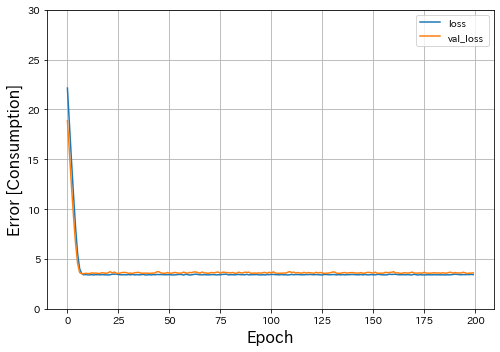

In [171]:
pfm.plot_loss(history)

In [172]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

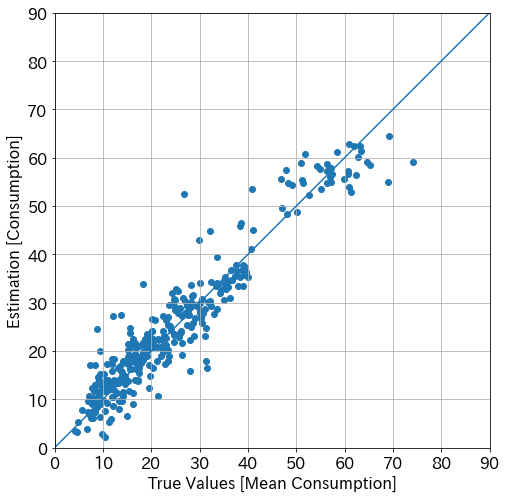

In [173]:
test_predictions = linear_model.predict(test_features).flatten()
pfm.plot_meanAndsum(test_labels, test_predictions)

In [174]:
test_dataset_interval["prediction_linear"] = test_predictions
test_dataset_interval["prediction_refuel_linear"] = test_dataset_interval["interval"] * test_dataset_interval["prediction_linear"]
MAE = mean_absolute_error(test_dataset_interval["volume"], test_dataset_interval["prediction_refuel_linear"])
print(MAE)

39.92975695828878


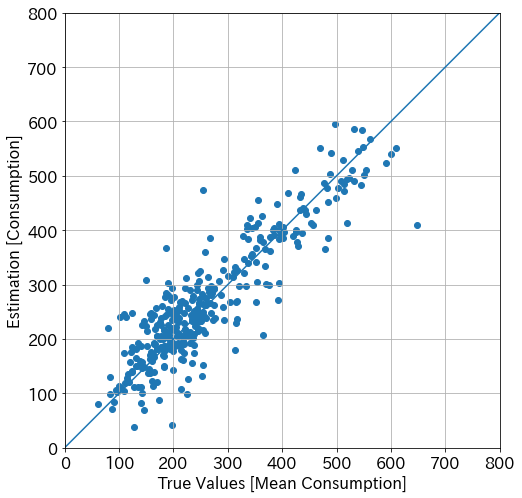

In [175]:
test_labels_sum = test_dataset_interval["volume"]
prediction = test_dataset_interval["prediction_refuel_linear"]
pfm.plot_meanAndsum(test_labels_sum, prediction, lims=[0,800])

In [176]:
error = (test_dataset_interval["prediction_refuel_linear"] - test_dataset_interval["volume"])/test_dataset_interval["volume"]
interval = test_dataset_interval["interval"]
#pfm.plot_interval(interval, error)

In [177]:
(test_dataset_interval["prediction_refuel_linear"].sum() - test_dataset_interval["volume"].sum())/test_dataset_interval["volume"].sum()

0.02282175201215966

In [178]:
error = test_predictions - test_labels
#pfm.plot_interval(interval, error, lims=[-30, 30])

In [179]:
error = (test_dataset_interval["prediction_refuel_linear"] - test_dataset_interval["volume"])/test_dataset_interval["volume"]
# pfm.plot_erroDistribution(error)

In [180]:
sf.error_distribution(error)

-0.2~0.2: 0.7082152974504249
>0.2: 0.19263456090651557
<-0.2: 0.09915014164305949


In [181]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='hard_sigmoid', kernel_regularizer=l2(0.001)),
      layers.Dense(64, activation='hard_sigmoid', kernel_regularizer=l2(0.001)),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [182]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 14)               29        
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                960       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,214
Trainable params: 5,185
Non-trainable params: 29
_________________________________________________________________


In [183]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=150)

Wall time: 8.07 s


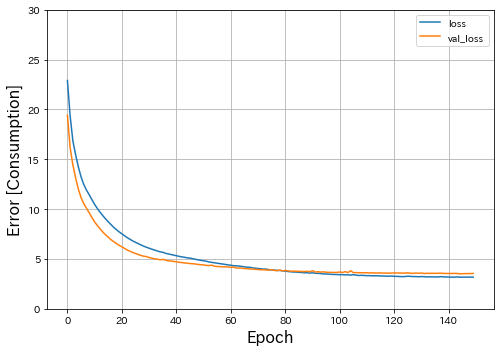

In [184]:
pfm.plot_loss(history)

In [185]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [186]:
test_results

{'linear_model': 3.354252576828003, 'dnn_model': 3.0625627040863037}

In [187]:
test_predictions = dnn_model.predict(test_features).flatten()
#pfm.plot_meanAndsum(test_labels, test_predictions)

In [188]:
test_dataset_interval["prediction_dnn"] = test_predictions
test_dataset_interval["prediction_refuel__dnn"] = test_dataset_interval["interval"] * test_dataset_interval["prediction_dnn"]
MAE = mean_absolute_error(test_dataset_interval["volume"], test_dataset_interval["prediction_refuel__dnn"])
print(MAE)

35.121491406524484


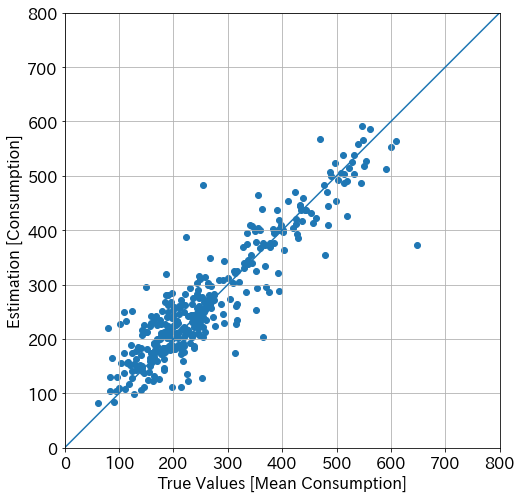

In [189]:
pfm.plot_meanAndsum(test_dataset_interval["volume"], test_dataset_interval["prediction_refuel__dnn"], lims=[0, 800])

In [190]:
error = (test_dataset_interval["prediction_refuel__dnn"] - test_dataset_interval["volume"])/test_dataset_interval["volume"]
#pfm.plot_interval(interval, error)

In [191]:
error = (test_dataset_interval["prediction_refuel__dnn"] - test_dataset_interval["volume"])/test_dataset_interval["volume"]
#pfm.plot_erroDistribution(error)

In [192]:
(test_dataset_interval["prediction_refuel__dnn"].sum() - test_dataset_interval["volume"].sum())/test_dataset_interval["volume"].sum()

0.02809469828592291

In [193]:
sf.error_distribution(error)

-0.2~0.2: 0.71671388101983
>0.2: 0.2096317280453258
<-0.2: 0.07365439093484419


In [194]:
error = test_predictions - test_labels
#pfm.plot_interval(interval, error, lims=[-30, 30])
#pfm.plot_erroDistribution(error)

In [195]:
linear_model.save(PATH_SAVE_LINEAR)
dnn_model.save(PATH_SAVE_DNN)
# hand made group use this line to save
# dnn_model.save("./models/" + GROUP_NAME+ "/dnn_model_hard_sigmoid")

INFO:tensorflow:Assets written to: ./Hierarchical_model/linear_model\assets
INFO:tensorflow:Assets written to: ./Hierarchical_model/dnn_model\assets
